In [185]:
%pip install --upgrade tensorflow
%pip install --upgrade tensorflow-probability 
%pip install --upgrade tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 262.6 kB/s eta 0:00:07
    --------------------------------------- 0.0/1.7 MB 281.8 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.7 MB 476.3 kB/s eta 0:00:04
   ----------- ---------------------------- 0.5/1.7 MB 2.3 MB/s eta 0:00:01
   ------------------------------------- -- 1.6/1.7 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  1.7/1.7 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [273]:
d = 2
def U(x):
    U_x = (x[:, 0:1] ** 2 - 1)**2 
    for i in range(1, d):
        U_x += 0.3 * (x[:, i:i+1])**2
    return U_x

In [431]:
class CRYOModel(tf.keras.Model):
    def __init__(self):
        super(CRYOModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense2 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense3 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.output_lay = tf.keras.layers.Dense(1, activation="sigmoid")
    
    def call(self, inputs):
        return self.output_lay(self.dense3(self.dense2(self.dense1(inputs))))

@tf.function
def loss(model, samples_O, samples_A, samples_B, beta=5, lamb=1000, eps=1e-6):
    V = U(samples_O)
    rho = tf.exp(-beta * V)
    Z = tf.reduce_mean(rho) * 3
    rho_tilde = 1.0/3.0
    weights = rho / (Z + eps) / rho_tilde
    
    q_A = model(samples_A)
    q_B = model(samples_B)
    
    with tf.GradientTape() as tape:
        tape.watch(samples_O)
        q_O_for_grad = model(samples_O)
    grad_q = tape.gradient(q_O_for_grad, samples_O)
    grad_norm_sq = tf.reduce_sum(tf.square(grad_q), axis=1, keepdims=True)
    loss_grad = tf.reduce_sum(grad_norm_sq * weights) / tf.reduce_sum(weights)
    
    loss_A = tf.reduce_mean(tf.square(q_A))
    loss_B = tf.reduce_mean(tf.square(q_B - 1.0))
    
    total_loss = loss_grad + lamb * (loss_A + loss_B)
    return total_loss


In [432]:
dim = 2
n = 5
num_samples = 10000
samples_A_x0 = tf.random.uniform((num_samples//4, 1), minval=-1, maxval=-0.75)
samples_A_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_A = tf.concat([samples_A_x0, samples_A_rest], axis=1)

samples_B_x0 = tf.random.uniform((num_samples//4, 1), minval=0.75, maxval=1)
samples_B_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_B = tf.concat([samples_B_x0, samples_B_rest], axis=1)

samples_O_x0 = tf.random.uniform((num_samples//2, 1), minval=-0.75, maxval=0.75)
samples_O_rest = tf.random.uniform((num_samples//2, dim-1), minval=-1, maxval=1)
samples_O = tf.concat([samples_O_x0, samples_O_rest], axis=1)

model = CRYOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss = loss(model, samples_O, samples_A, samples_B)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    q_A_vals = model(samples_A)
    q_B_vals = model(samples_B)
    q_O_vals = model(samples_O)

    if epoch % 100 == 0:
        print("q_A mean:", tf.reduce_mean(q_A_vals).numpy())
        print("q_B mean:", tf.reduce_mean(q_B_vals).numpy())
        print("q_O range:", tf.reduce_min(q_O_vals).numpy(), tf.reduce_max(q_O_vals).numpy())
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}") 

q_A mean: 0.48143086
q_B mean: 0.5302907
q_O range: 0.44991112 0.5612537
Epoch 0, Total Loss: 523.8244018554688
q_A mean: 0.012019304
q_B mean: 0.9879303
q_O range: 0.017458018 0.98245674
Epoch 100, Total Loss: 0.41470155119895935
q_A mean: 0.008280819
q_B mean: 0.9916651
q_O range: 0.012291914 0.9876618
Epoch 200, Total Loss: 0.2511473298072815
q_A mean: 0.006279545
q_B mean: 0.9936513
q_O range: 0.009453903 0.99044573
Epoch 300, Total Loss: 0.1891038417816162
q_A mean: 0.005077095
q_B mean: 0.99484295
q_O range: 0.0077187563 0.9921363
Epoch 400, Total Loss: 0.16070497035980225
q_A mean: 0.0042861137
q_B mean: 0.99562734
q_O range: 0.006563019 0.99327666
Epoch 500, Total Loss: 0.14584650099277496
q_A mean: 0.0037318203
q_B mean: 0.9961783
q_O range: 0.0057456004 0.994085
Epoch 600, Total Loss: 0.13734734058380127
q_A mean: 0.0033255753
q_B mean: 0.9965834
q_O range: 0.0051423497 0.9946838
Epoch 700, Total Loss: 0.13218218088150024
q_A mean: 0.0030179722
q_B mean: 0.9968918
q_O range: 

In [426]:
test = tf.random.uniform((1000, dim), minval = -1, maxval=1)
u_pred = model(test)


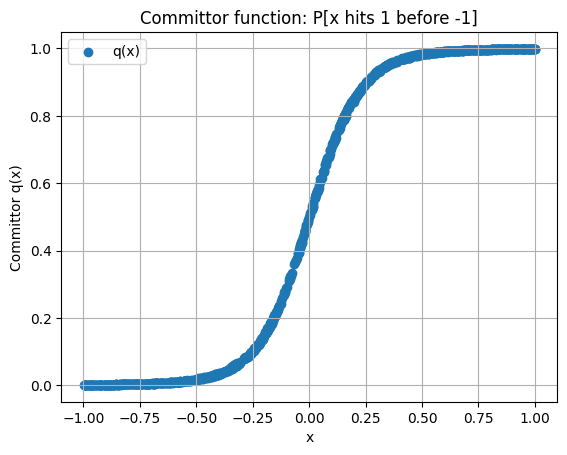

In [427]:
plt.scatter(test[:, 0], u_pred, label="q(x)")
plt.xlabel("x")
plt.ylabel("Committor q(x)")
plt.title("Committor function: P[x hits 1 before -1]")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# New attempt
dim = 2
n = 5
num_samples = 10000
samples_A_x0 = tf.random.uniform((num_samples//4, 1), minval=-0.75, maxval=-0.7)
samples_A_rest = tf.random.uniform((num_samples//4, dim-1))
samples_A = tf.concat([samples_A_x0, samples_A_rest], axis=1)

samples_B_x0 = tf.random.uniform((num_samples//4, 1), minval=0.7, maxval=0.7)
samples_B_rest = tf.random.uniform((num_samples//4, dim-1))
samples_B = tf.concat([samples_B_x0, samples_B_rest], axis=1)

samples_O_x0 = tf.random.uniform((num_samples//2, 1), minval=-0.7, maxval=0.7)
samples_O_rest = tf.random.uniform((num_samples//2, dim-1))
samples_O = tf.concat([samples_O_x0, samples_O_rest], axis=1)

samples = tf.concat([samples_A, samples_B, samples_O], axis=0)

def R(q):
    return q**(1.0/n)/(q**(1.0/n) + (1-q)**(1.0/n))

def dU(x):
    dU_x1 = 4.0 * (x[:, 0:1] ** 2 - 1) * x[:, 0:1]
    for i in range(1, d):
        dU_x1 = tf.concat([dU_x1,
         0.6 * x[:, i:i+1]], axis=1)
    return dU_x1

def is_in_region_B(x):
    return x[:, 0] > 0.75

def is_in_region_A(x):
    return x[:, 0] < -0.75
K = 1
I = 4000
width = 0.1
height = 0.3
dt = 0.1
Time = 0.5
T = 0.05
k_B = 1.380649e-23

model = CRYOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

q = [model(samples)]
r = [R(q[0])]

for k in range(1, K + 1):
    t = 0
    x_t = tf.Variable(samples)
    V_m = 0
    active = active_mask = tf.ones(shape=(samples.shape[0],), dtype=tf.bool)
    while t < Time and tf.reduce_any(active_mask):
        with tf.GradientTape() as tape:
            tape.watch(x_t)
            q = model(x_t)
            r_val = R(q) 
            r_diff = r[k - 1] - r_val
            V_m = height * tf.exp(-tf.square(r_diff) / (2 * width**2))

        dq_dx = tape.gradient(q, x_t)  
        dR_dq = (q**(1/n - 1) * (1 - q)**(1/n - 1)) * (1/n) / (q**(1/n) + (1 - q)**(1/n))**2
        dR_dx = tf.expand_dims(dR_dq, axis=1) * dq_dx

        dVm_dr = -r_diff / (width**2) * V_m 
        print(dVm_dr.shape)
        dVm_dr_flat = tf.squeeze(dVm_dr, axis=1)
        grad_Vm = dVm_dr_flat * dR_dx

        force = -dU(x_t) - grad_Vm
        print(grad_Vm.shape)

        noise = tf.sqrt(dt * T * k_B * 2) * tf.random.normal(shape=x_t.shape)
        dx = force * dt + noise

        dx = tf.where(tf.expand_dims(active_mask, axis=1), dx, tf.zeros_like(dx))
        x_t.assign_add(dx)

        in_A = is_in_region_A(x_t)
        in_B = is_in_region_B(x_t)
        active_mask = tf.logical_and(active_mask, tf.logical_not(tf.logical_or(in_A, in_B)))

        t += dt

(10000, 1)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [10000] vs. [10000,10000,2] [Op:Mul] name: 